In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [4]:
# Load cleaned data
bnd = pd.read_csv("../data/BND_cleaned.csv", parse_dates=["Date"], index_col="Date")
spy = pd.read_csv("../data/SPY_cleaned.csv", parse_dates=["Date"], index_col="Date")
tsla = pd.read_csv("../data/TSLA_cleaned.csv", parse_dates=["Date"], index_col="Date")

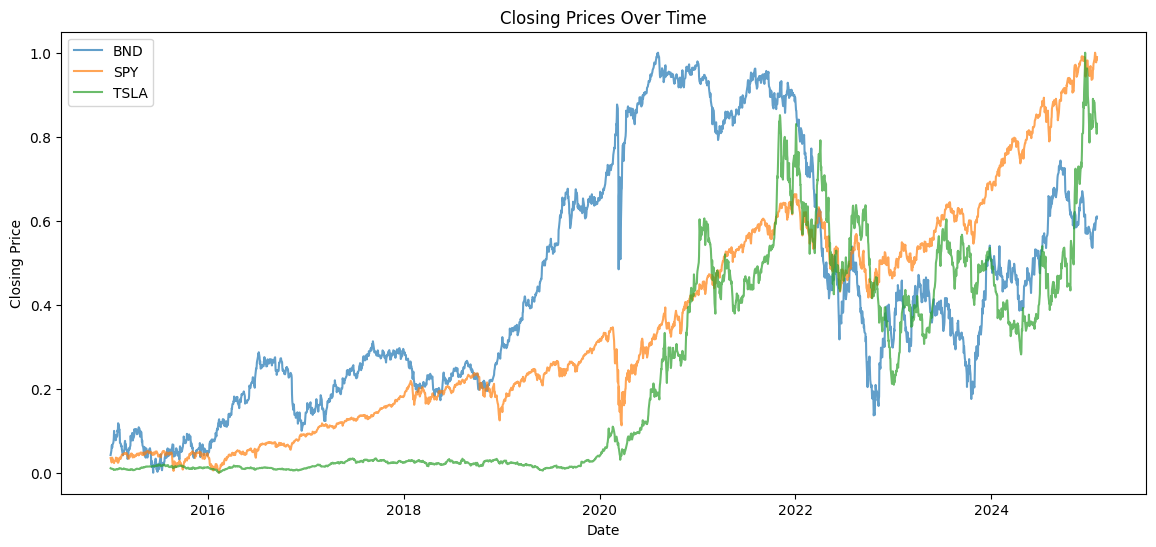

In [5]:
# Plot closing prices
plt.figure(figsize=(14, 6))
plt.plot(bnd.index, bnd['Close'], label='BND', alpha=0.7)
plt.plot(spy.index, spy['Close'], label='SPY', alpha=0.7)
plt.plot(tsla.index, tsla['Close'], label='TSLA', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing Prices Over Time")
plt.legend()
plt.show()

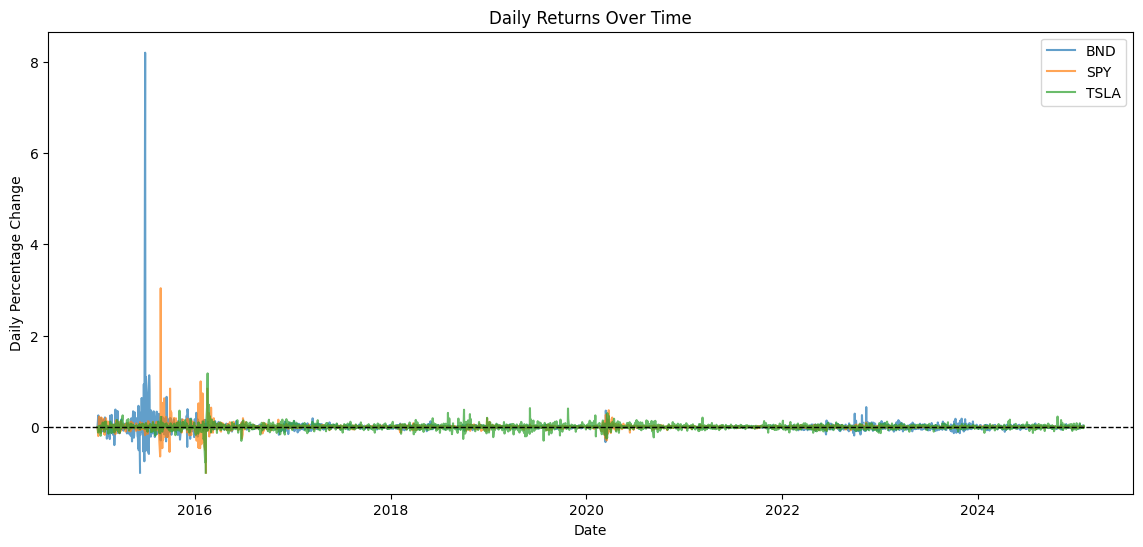

In [11]:
# Calculate and plot daily percentage change
bnd['Daily Return'] = bnd['Close'].pct_change().fillna(0)
spy['Daily Return'] = spy['Close'].pct_change().fillna(0)
tsla['Daily Return'] = tsla['Close'].pct_change().fillna(0)

plt.figure(figsize=(14, 6))
plt.plot(bnd.index, bnd['Daily Return'], label='BND', alpha=0.7)
plt.plot(spy.index, spy['Daily Return'], label='SPY', alpha=0.7)
plt.plot(tsla.index, tsla['Daily Return'], label='TSLA', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.xlabel("Date")
plt.ylabel("Daily Percentage Change")
plt.title("Daily Returns Over Time")
plt.legend()
plt.show()

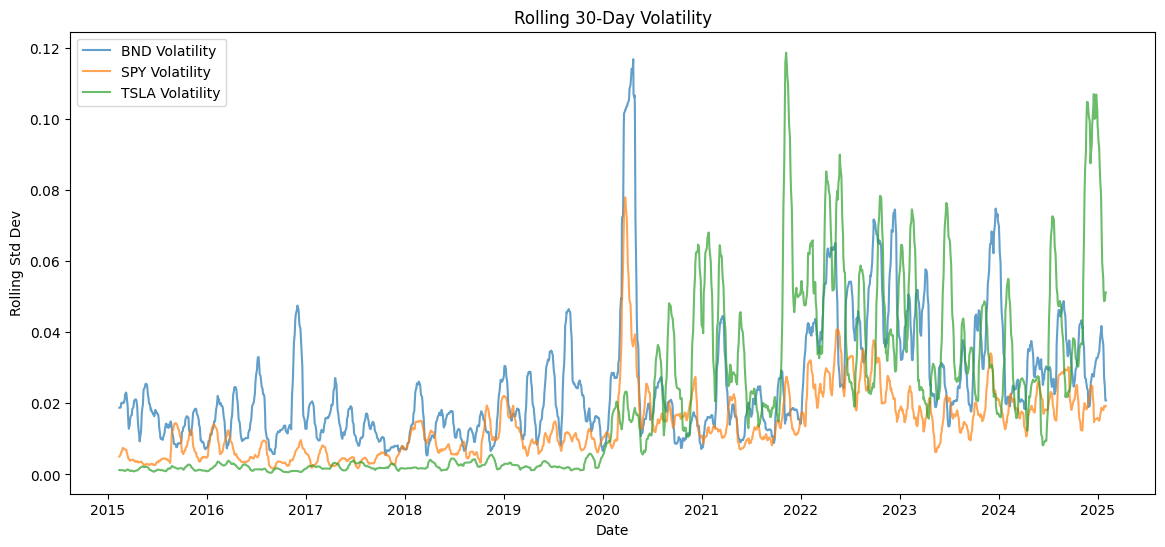

In [12]:
# Analyze volatility (rolling mean & std)
plt.figure(figsize=(14, 6))
plt.plot(bnd.index, bnd['Close'].rolling(30).std(), label='BND Volatility', alpha=0.7)
plt.plot(spy.index, spy['Close'].rolling(30).std(), label='SPY Volatility', alpha=0.7)
plt.plot(tsla.index, tsla['Close'].rolling(30).std(), label='TSLA Volatility', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Rolling Std Dev")
plt.title(f"Rolling 30-Day Volatility")
plt.legend()
plt.show()

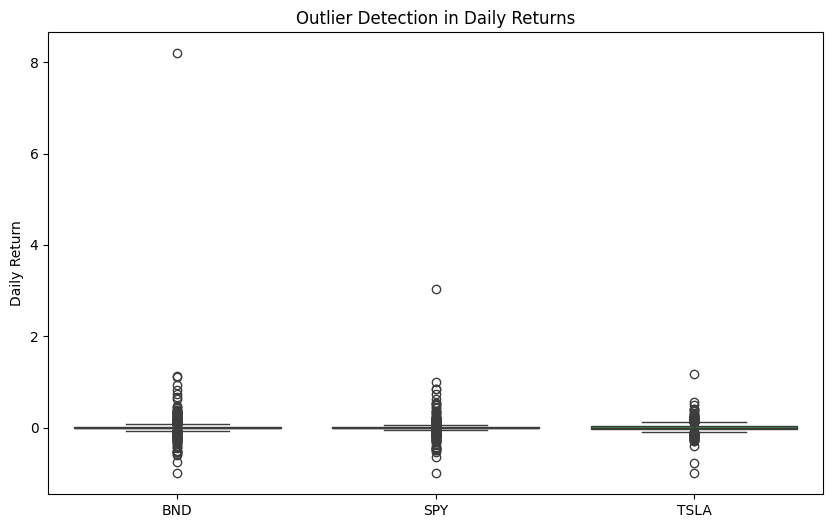

Outlier Count:
BND     0
SPY     0
TSLA    0
dtype: int64


/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [13]:
# Detect outliers in daily returns
data = pd.DataFrame({
    'BND': bnd['Daily Return'],
    'SPY': spy['Daily Return'],
    'TSLA': tsla['Daily Return']
})
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
plt.title("Outlier Detection in Daily Returns")
plt.ylabel("Daily Return")
plt.show()

# Z-score analysis for outliers
z_scores = (data - data.mean()) / data.std()
outliers = (z_scores.abs() > 3).sum()
print("Outlier Count:")
print(outliers)

In [17]:
# Define function to extract numerical insights
def extract_numerical_insights(data, name):
    insights = {}
    df = data.copy()

    # Closing price trends
    insights['Max_Close'] = df['Close'].max()
    insights['Min_Close'] = df['Close'].min()
    insights['Avg_Close'] = df['Close'].mean()
    
    # Volatility (daily percentage change)
    df['Daily_Change'] = df['Close'].pct_change()
    insights['Max_Daily_Change'] = df['Daily_Change'].max()
    insights['Min_Daily_Change'] = df['Daily_Change'].min()
    insights['Avg_Daily_Change'] = df['Daily_Change'].mean()
    
    # Rolling statistics (30-day rolling window)
    df['Rolling_Mean'] = df['Close'].rolling(window=30).mean()
    df['Rolling_Std'] = df['Close'].rolling(window=30).std()
    insights['Avg_Rolling_Mean'] = df['Rolling_Mean'].mean()
    insights['Avg_Rolling_Std'] = df['Rolling_Std'].mean()
    
    # Outlier detection (based on 3 standard deviations)
    mean_change = insights['Avg_Daily_Change']
    std_change = df['Daily_Change'].std()
    outliers = df[(df['Daily_Change'] > mean_change + 3 * std_change) | 
                  (df['Daily_Change'] < mean_change - 3 * std_change)]
    
    insights['Num_Outliers'] = len(outliers)
    insights['Max_Outlier_Change'] = outliers['Daily_Change'].max() if not outliers.empty else np.nan
    insights['Min_Outlier_Change'] = outliers['Daily_Change'].min() if not outliers.empty else np.nan
    
    return pd.DataFrame(insights, index=[name])

# Apply function to each dataset
bnd_insights = extract_numerical_insights(bnd, "BND")
spy_insights = extract_numerical_insights(spy, "SPY")
tsla_insights = extract_numerical_insights(tsla, "TSLA")

# Combine results
numerical_summary = pd.concat([bnd_insights, spy_insights, tsla_insights])

# Display numerical insights
print(numerical_summary)

      Max_Close  Min_Close  Avg_Close  Max_Daily_Change  Min_Daily_Change  \
BND         1.0        0.0   0.437945               inf              -1.0   
SPY         1.0        0.0   0.351621               inf              -1.0   
TSLA        1.0        0.0   0.230224               inf              -1.0   

      Avg_Daily_Change  Avg_Rolling_Mean  Avg_Rolling_Std  Num_Outliers  \
BND                inf          0.439211         0.024816             0   
SPY                inf          0.349896         0.013713             0   
TSLA               inf          0.227927         0.020628             0   

      Max_Outlier_Change  Min_Outlier_Change  
BND                  NaN                 NaN  
SPY                  NaN                 NaN  
TSLA                 NaN                 NaN  


/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


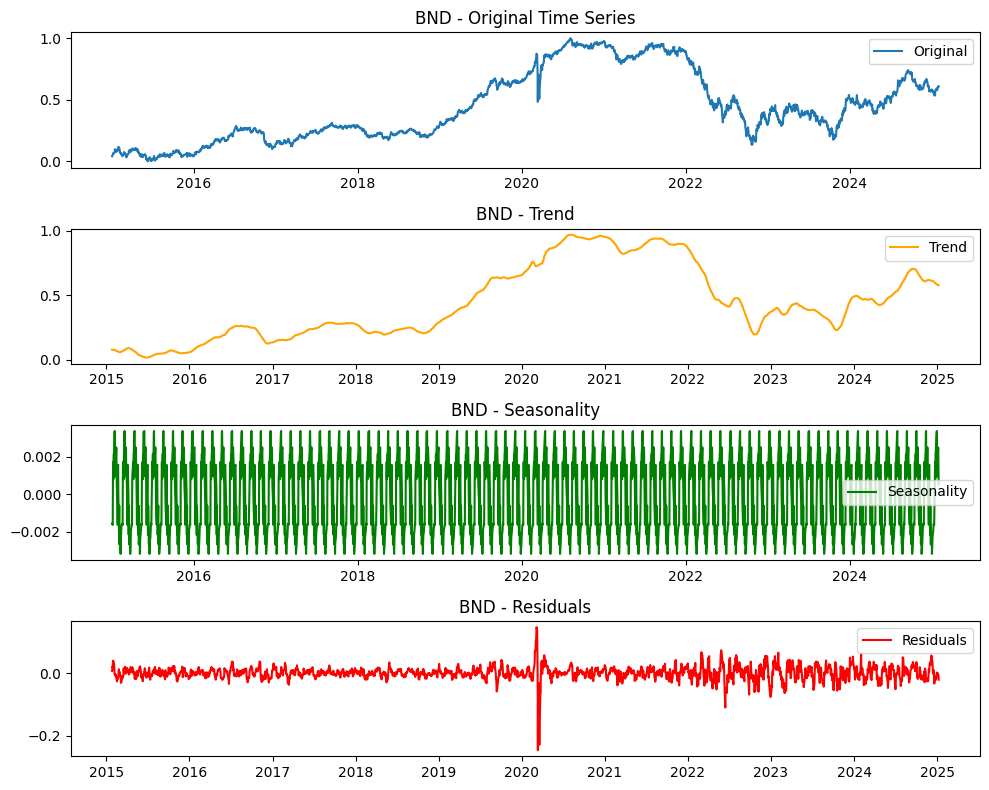

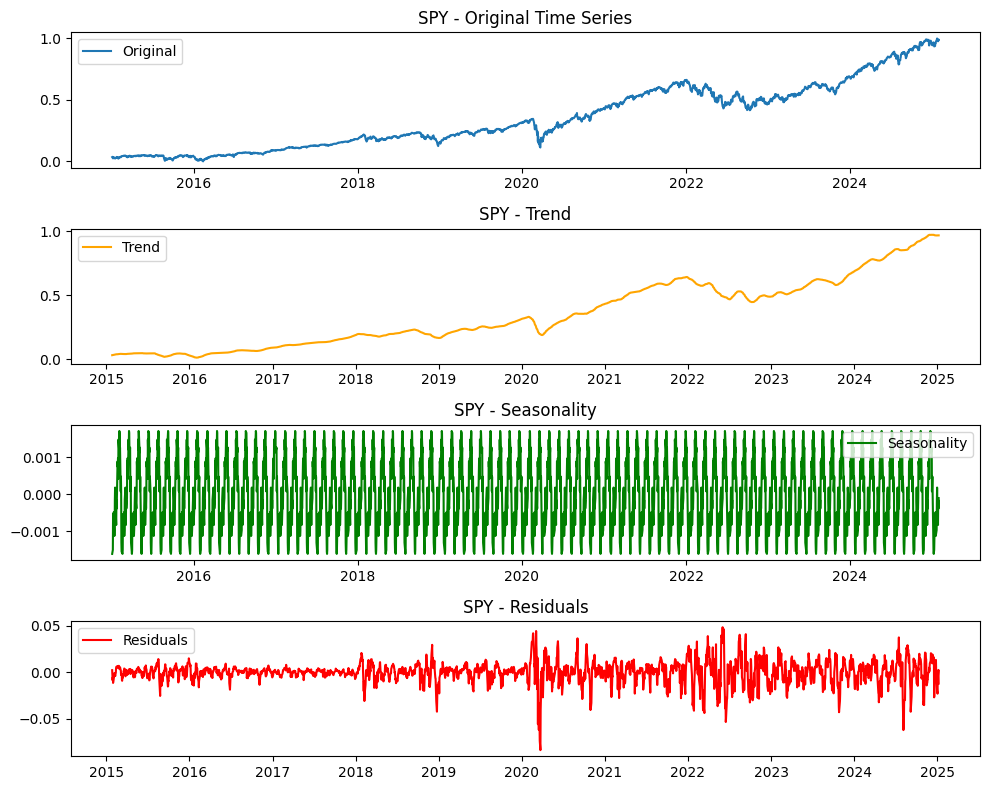

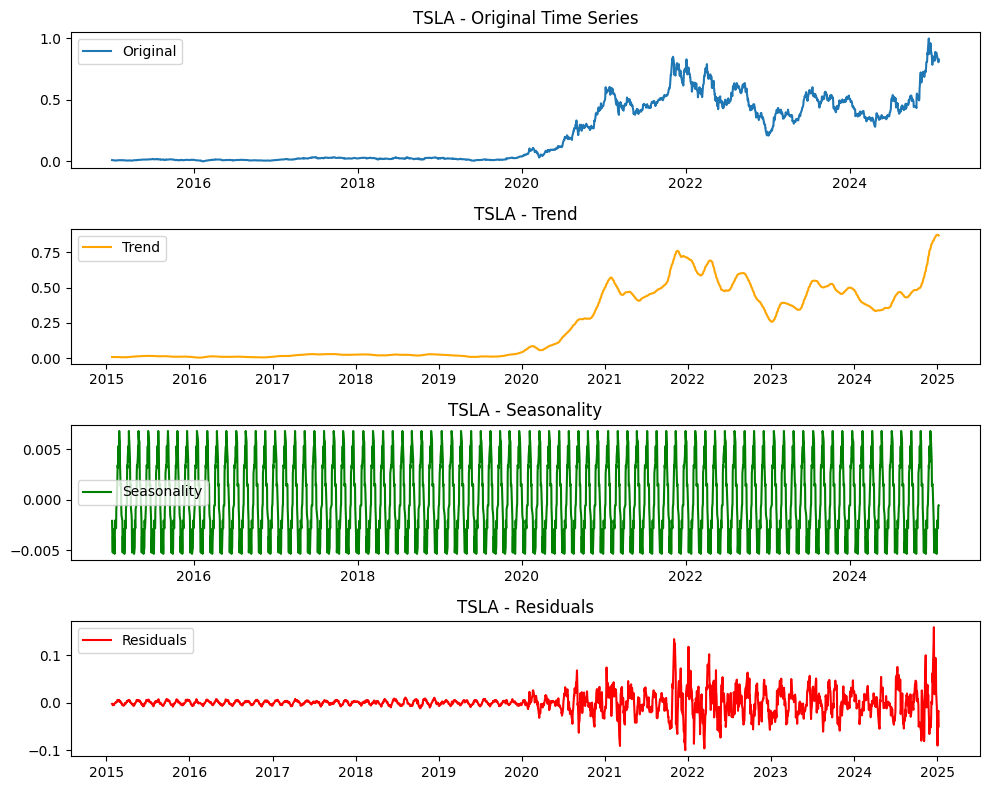

In [20]:
def decompose_time_series(df, stock_name):
    df = df.dropna()
    decomposition = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=30)

    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(10, 8))
    axes[0].plot(df['Close'], label="Original")
    axes[0].set_title(f'{stock_name} - Original Time Series')
    axes[1].plot(decomposition.trend, label="Trend", color='orange')
    axes[1].set_title(f'{stock_name} - Trend')
    axes[2].plot(decomposition.seasonal, label="Seasonality", color='green')
    axes[2].set_title(f'{stock_name} - Seasonality')
    axes[3].plot(decomposition.resid, label="Residuals", color='red')
    axes[3].set_title(f'{stock_name} - Residuals')
    
    for ax in axes:
        ax.legend()
    plt.tight_layout()
    plt.show()

    return decomposition

# Apply decomposition to each stock dataset
bnd_decomp = decompose_time_series(bnd, "BND")
spy_decomp = decompose_time_series(spy, "SPY")
tsla_decomp = decompose_time_series(tsla, "TSLA")

In [21]:
def extract_decomposition_data(decomp, stock_name):
    insights = {
        'Max_Trend': decomp.trend.max(),
        'Min_Trend': decomp.trend.min(),
        'Max_Seasonality': decomp.seasonal.max(),
        'Min_Seasonality': decomp.seasonal.min(),
        'Max_Residual': decomp.resid.max(),
        'Min_Residual': decomp.resid.min()
    }
    return pd.DataFrame(insights, index=[stock_name])

# Collect results
bnd_decomp_data = extract_decomposition_data(bnd_decomp, "BND")
spy_decomp_data = extract_decomposition_data(spy_decomp, "SPY")
tsla_decomp_data = extract_decomposition_data(tsla_decomp, "TSLA")

# Combine all results
decomposition_summary = pd.concat([bnd_decomp_data, spy_decomp_data, tsla_decomp_data])

# Display decomposition insights
print(decomposition_summary)

      Max_Trend  Min_Trend  Max_Seasonality  Min_Seasonality  Max_Residual  \
BND    0.969408   0.018310         0.003381        -0.003170      0.146419   
SPY    0.972089   0.012723         0.001714        -0.001611      0.048462   
TSLA   0.874805   0.004799         0.006789        -0.005342      0.158730   

      Min_Residual  
BND      -0.246463  
SPY      -0.083952  
TSLA     -0.099870  


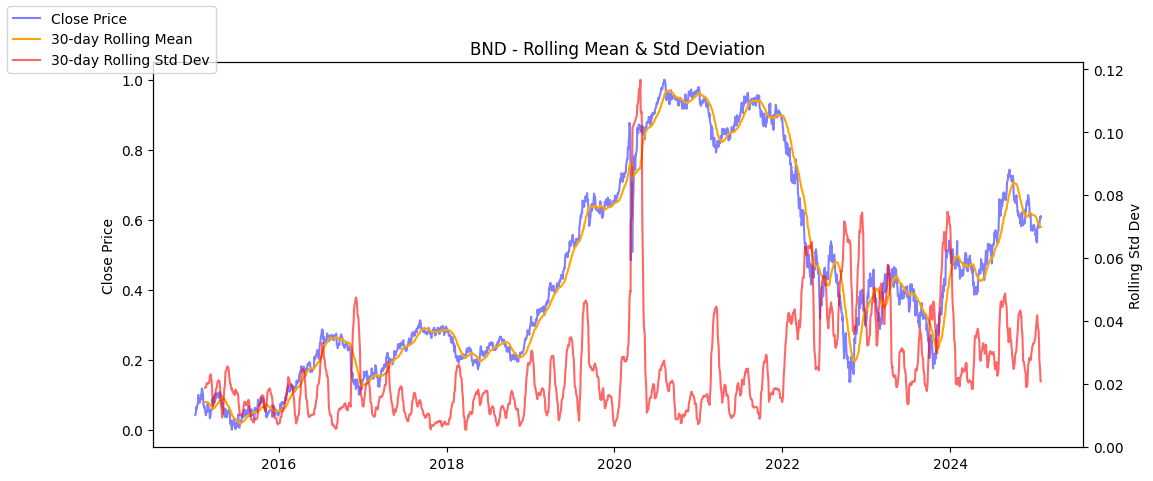

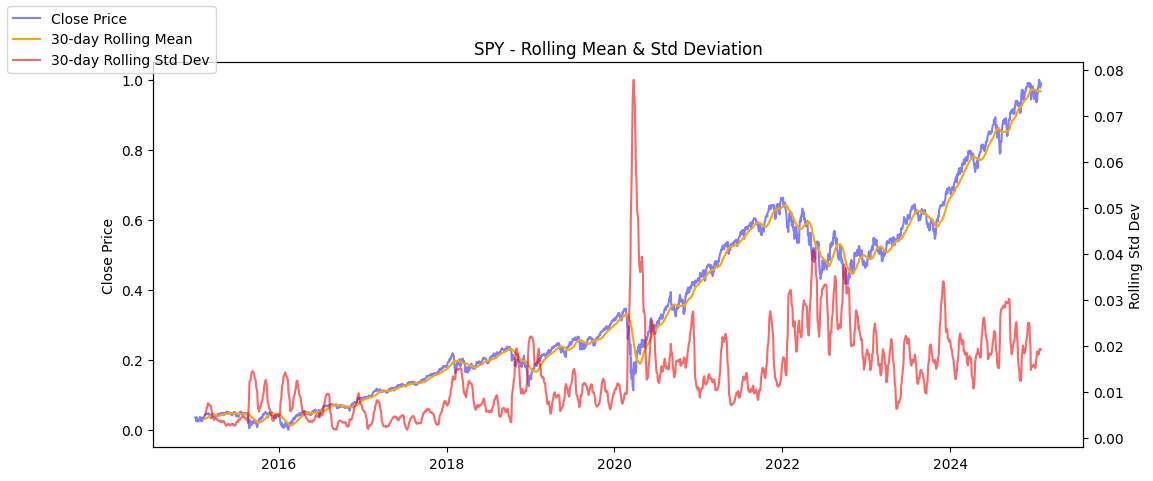

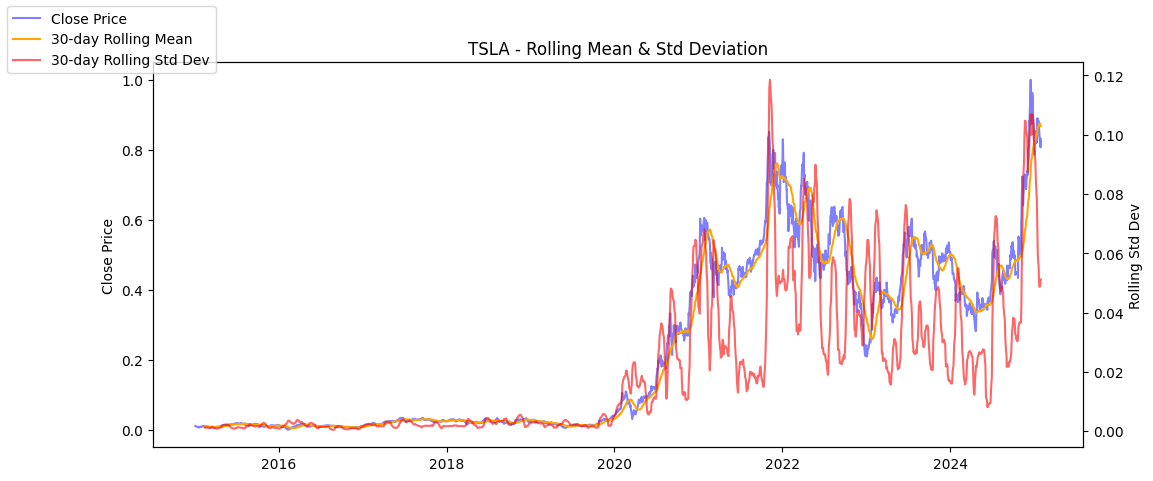

In [23]:
def compute_rolling_stats(df, stock_name, window=30):
    df['Rolling_Mean'] = df['Close'].rolling(window=window).mean()
    df['Rolling_Std'] = df['Close'].rolling(window=window).std()

    # Plot Rolling Mean & Rolling Std
    fig, ax1 = plt.subplots(figsize=(12, 5))

    ax1.plot(df['Close'], label="Close Price", color='blue', alpha=0.5)
    ax1.plot(df['Rolling_Mean'], label=f'{window}-day Rolling Mean', color='orange')
    ax1.set_ylabel('Close Price')
    ax1.set_title(f'{stock_name} - Rolling Mean & Std Deviation')

    ax2 = ax1.twinx()
    ax2.plot(df['Rolling_Std'], label=f'{window}-day Rolling Std Dev', color='red', alpha=0.6)
    ax2.set_ylabel('Rolling Std Dev')

    fig.legend(loc="upper left")
    plt.show()

    return df[['Rolling_Mean', 'Rolling_Std']]

# Apply rolling stats to each stock dataset
bnd_stats = compute_rolling_stats(bnd, "BND")
spy_stats = compute_rolling_stats(spy, "SPY")
tsla_stats = compute_rolling_stats(tsla, "TSLA")


In [25]:
def extract_volatility_stats(df, stock_name):
    stats = {
        'Stock': stock_name,
        'Max_Rolling_Mean': df['Rolling_Mean'].max(),
        'Min_Rolling_Mean': df['Rolling_Mean'].min(),
        'Max_Rolling_Std': df['Rolling_Std'].max(),
        'Min_Rolling_Std': df['Rolling_Std'].min(),
        'Avg_Rolling_Std': df['Rolling_Std'].mean()
    }
    return stats

# Compute volatility stats for each stock
bnd_vol_stats = extract_volatility_stats(bnd, "BND")
spy_vol_stats = extract_volatility_stats(spy, "SPY")
tsla_vol_stats = extract_volatility_stats(tsla, "TSLA")

# Convert results to a DataFrame
volatility_summary = pd.DataFrame([bnd_vol_stats, spy_vol_stats, tsla_vol_stats])
print(volatility_summary)

  Stock  Max_Rolling_Mean  Min_Rolling_Mean  Max_Rolling_Std  Min_Rolling_Std  \
0   BND          0.969436          0.018232         0.116712         0.005352   
1   SPY          0.972201          0.012700         0.077884         0.001693   
2  TSLA          0.874941          0.004797         0.118537         0.000482   

   Avg_Rolling_Std  
0         0.024816  
1         0.013713  
2         0.020628  


In [26]:
def calculate_risk_metrics(df, stock_name, risk_free_rate=0.02):
    # Calculate daily returns
    df['Daily_Return'] = df['Close'].pct_change()
    
    # Calculate Value at Risk (VaR) at 95% confidence
    var_95 = np.percentile(df['Daily_Return'].dropna(), 5)
    
    # Calculate Sharpe Ratio
    avg_return = df['Daily_Return'].mean()
    std_dev = df['Daily_Return'].std()
    sharpe_ratio = (avg_return - risk_free_rate/252) / std_dev

    return {
        'Stock': stock_name,
        'VaR_95': var_95,
        'Sharpe_Ratio': sharpe_ratio
    }

# Compute risk metrics
bnd_risk = calculate_risk_metrics(bnd, "BND")
spy_risk = calculate_risk_metrics(spy, "SPY")
tsla_risk = calculate_risk_metrics(tsla, "TSLA")

# Convert to DataFrame
risk_summary = pd.DataFrame([bnd_risk, spy_risk, tsla_risk])
print(risk_summary)

  Stock    VaR_95  Sharpe_Ratio
0   BND -0.079021           NaN
1   SPY -0.058486           NaN
2  TSLA -0.084389           NaN


/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
